# LR schedule development

Just playing with some LR schedules and visualizing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
base_lr = 0.001
lr_scaling = 'sqrt'

In [4]:
ranks = 2**np.arange(11)

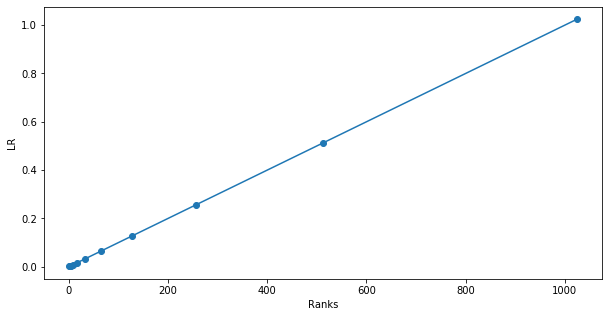

In [5]:
plt.figure(figsize=(10, 5))

plt.plot(ranks, base_lr * ranks, 'o-')
plt.xlabel('Ranks')
plt.ylabel('LR');

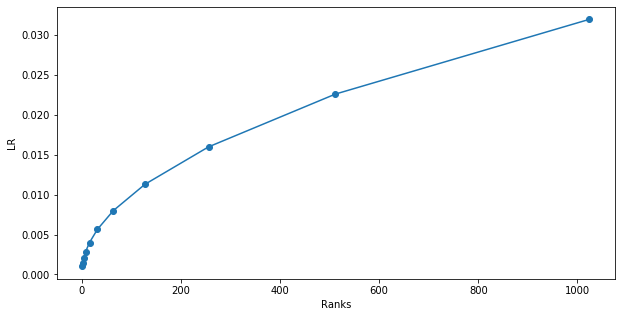

In [6]:
plt.figure(figsize=(10,5))

plt.plot(ranks, base_lr * np.sqrt(ranks), 'o-')
plt.xlabel('Ranks')
plt.ylabel('LR');

## LR schedule function

Here I want to try and define a function which will work with the Keras LR scheduler API.
The design of this callback is such that I need a function which takes the current epoch and LR and returns the new LR. One could simply define a function that maps epoch onto LR and ignore the current LR, though. In fact in this case the latter approach would be a bit easier.

In [7]:
from functools import partial

In [8]:
def lr_schedule(epoch, base_lr, peak_lr, n_warmup_epochs, decay_schedule={}):
    # Linear LR warmup
    if epoch < n_warmup_epochs:
        return epoch * (peak_lr - base_lr) / n_warmup_epochs + base_lr
    else:
        # Find the most recent decay factor
        decay_factor = 1.
        decay_epoch = 0
        for e, d in decay_schedule.items():
            if e >= decay_epoch and e < epoch:
                decay_epoch, decay_factor = e, d
            
        return peak_lr * decay_factor

In [9]:
# Linear LR scaling
base_lr = 0.001
n_ranks = 16
peak_lr = base_lr * n_ranks
n_warmup_epochs = 4
n_epochs = 64

decay_schedule = {16:.5, 32:.1}

_lr_sched = partial(lr_schedule, base_lr=base_lr, peak_lr=peak_lr, n_warmup_epochs=n_warmup_epochs, decay_schedule=decay_schedule)

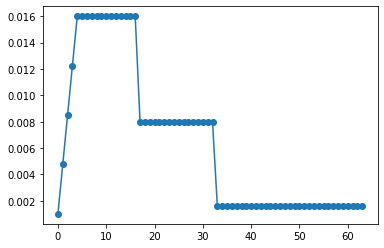

In [10]:
plt.figure()

epochs = np.arange(n_epochs)
lr = np.array([_lr_sched(e) for e in epochs])

plt.plot(epochs, lr, 'o-')

In [11]:
# SQRT LR scaling
base_lr = 0.001
n_ranks = 64
peak_lr = base_lr * np.sqrt(n_ranks)
n_warmup_epochs = 8
n_epochs = 64

decay_schedule = {32:.5, 48:.25}

_lr_sched = partial(lr_schedule, base_lr=base_lr, peak_lr=peak_lr, n_warmup_epochs=n_warmup_epochs, decay_schedule=decay_schedule)

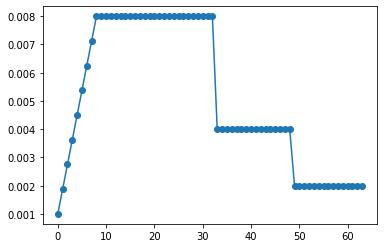

In [12]:
plt.figure()

epochs = np.arange(n_epochs)
lr = np.array([_lr_sched(e) for e in epochs])

plt.plot(epochs, lr, 'o-')

## Sampling learning rates in random search

How does a log uniform sampling look?

In [13]:
# I should be able to sample LR with something like this
10**np.random.uniform(-5, -1, size=32)

array([2.13723027e-03, 3.67404813e-02, 1.07329902e-05, 2.29884151e-05,
       1.64455604e-05, 1.28254193e-04, 8.11339952e-02, 7.35782591e-02,
       1.38861564e-04, 2.15948822e-05, 3.28793278e-03, 9.78011147e-03,
       5.92725842e-03, 6.10786339e-03, 1.47168779e-03, 3.01039408e-05,
       1.09983345e-02, 1.64876288e-03, 2.15035985e-02, 1.75018016e-02,
       9.91622047e-04, 2.84804127e-04, 1.33522189e-02, 1.10467637e-04,
       3.10957589e-04, 7.33384264e-04, 8.04361554e-05, 2.65138121e-02,
       5.07703137e-03, 2.99325988e-03, 1.12432523e-03, 1.43886205e-02])

In [14]:
import math

def linear_lr(b, base_lr=0.01, base_batch=512):
    return base_lr * b / base_batch

def sqrt_lr(b, base_lr=0.01, base_batch=512):
    return base_lr * np.sqrt(b / base_batch)

## Plot peak LR for different parameter choices

In [19]:
plt.rcParams['font.size'] = 14.0

In [22]:
settings = [
    #(0.01, 512, sqrt_lr),
    (0.0025, 32, sqrt_lr),
    (0.01, 512, linear_lr),
    (0.001, 64, linear_lr),
    (0.008, 512, sqrt_lr)
]

batch_size = 2**np.arange(3, 11)

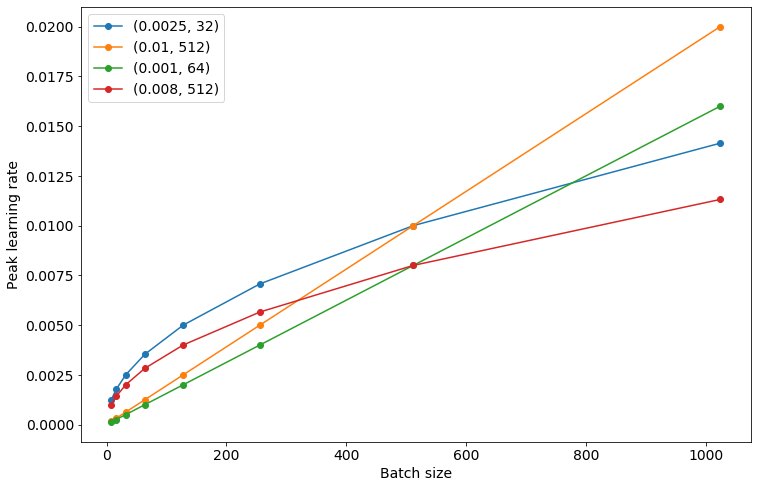

In [23]:
plt.figure(figsize=(12,8))

for base_lr, base_batch, scale_lr in settings:    
    plt.plot(batch_size, scale_lr(batch_size, base_lr, base_batch), 'o-', label=(base_lr, base_batch))

plt.legend(loc=0)
plt.xlabel('Batch size')
plt.ylabel('Peak learning rate');